In [1]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import robust_loss_pytorch.general


# Construct some regression data with some extreme outliers.
np.random.seed(1)
n = 100
scale_true = 0.7
shift_true = 0.15
scale2_true = 2
p = 0.5 # rate to be a member of one group
U = np.random.binomial(1, p, n)

x = np.random.uniform(size=n)
y = scale_true * x + shift_true
y[U==1] = scale2_true * x[U==1]**2 + shift_true
y += np.random.normal(scale=0.025, size=n)
flip_mask = np.random.uniform(size=n) > 0.9
y = np.where(flip_mask, 0.05 + 0.4 * (1. - np.sign(y - 0.5)), y)

x = torch.Tensor(x)
y = torch.Tensor(y)
U = torch.Tensor(U)

class RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(1, 1)
    def forward(self, x): 
        return self.linear(x[:,None])[:,0]
    
class Poly2RegressionModel(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(2, 1)
    def forward(self, x): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        return self.linear(x)[:,0]
    
class Poly2RegressionModel_with_class(torch.nn.Module): 
    # A simple linear regression module.
    def __init__(self): 
        super(Poly2RegressionModel_with_class, self).__init__() 
        self.linear = torch.nn.Linear(3, 1)
    def forward(self, x, c): 
        x = torch.cat([(x**2).view(-1,1), x.view(-1,1)], axis=1)
        x = torch.cat([x, c.view(-1,1)], axis=1)
        return self.linear(x)[:,0]

def plot_regression(regression, u=None, c=None):
    # A helper function for plotting a regression module.
    x_plot = np.linspace(0, 1, 100)
    if c is None:
        y_plot = regression(torch.Tensor(x_plot)).detach().numpy()
    else:
        y_plot = regression(torch.Tensor(x_plot), c).detach().numpy()
    y_plot_true = x_plot * scale_true + shift_true
    
    plt.figure(0, figsize=(4,4))
    if u is not None:
        sns.scatterplot(x, y, hue=U)
    else:
        sns.scatterplot(x, y)
#     plt.plot(x_plot, y_plot_true, color='k')
    plt.plot(x_plot, y_plot, color='navy', label='regressor')
    plt.legend()

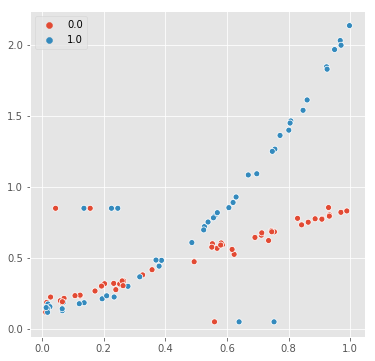

In [2]:
plt.figure(0, figsize=(6,6))
sns.scatterplot(x, y, hue=U)

## Linear regression with regular MSE

0   : loss=26.179207
100 : loss=8.221217
200 : loss=6.255218
300 : loss=5.643476
400 : loss=5.526091
500 : loss=5.511484
600 : loss=5.510287
700 : loss=5.510223
800 : loss=5.510221
900 : loss=5.510221
1000: loss=5.510221
1100: loss=5.510221
1200: loss=5.510221
1300: loss=5.510221
1400: loss=5.510221
1500: loss=5.510221
1600: loss=5.510221
1700: loss=5.510221
1800: loss=5.510221
1900: loss=5.510221


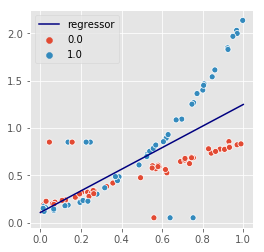

In [3]:
# Fit a linear regression using mean squared error.
regression = RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(
        y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression, U)

0   : loss=145.625473
100 : loss=8.872115
200 : loss=5.329909
300 : loss=5.239791
400 : loss=5.193936
500 : loss=5.173508
600 : loss=5.164361
700 : loss=5.159091
800 : loss=5.154798
900 : loss=5.150603
1000: loss=5.146311
1100: loss=5.141909
1200: loss=5.137421
1300: loss=5.132882
1400: loss=5.128322
1500: loss=5.123772
1600: loss=5.119264
1700: loss=5.114825
1800: loss=5.110485
1900: loss=5.106266


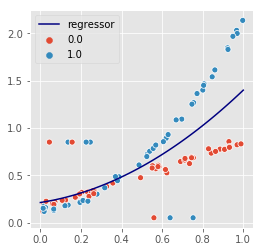

In [4]:
# Fit a linear regression with 2D base expansion using mean squared error.
regression = Poly2RegressionModel() 
params = regression.parameters()
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Hijacking the general loss to compute MSE.
    loss = torch.mean(robust_loss_pytorch.general.lossfun(y_i - y, alpha=torch.Tensor([2.]), scale=torch.Tensor([0.1])))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        print('{:<4}: loss={:03f}'.format(epoch, loss.data)) 

# It doesn't fit well.
plot_regression(regression, U)

## Linear regression with Adaptive Roust loss

0   : loss=1.534314  alpha=1.004995  scale=0.993690
100 : loss=0.516633  alpha=1.456943  scale=0.441359
200 : loss=0.293999  alpha=1.603991  scale=0.264245
300 : loss=0.288713  alpha=1.514505  scale=0.250495
400 : loss=0.279905  alpha=1.361357  scale=0.233923
500 : loss=0.263491  alpha=1.114030  scale=0.208559
600 : loss=0.227565  alpha=0.744228  scale=0.169016
700 : loss=0.145659  alpha=0.347257  scale=0.113024
800 : loss=0.036277  alpha=0.128451  scale=0.065518
900 : loss=-0.023541  alpha=0.054304  scale=0.044364
1000: loss=-0.041921  alpha=0.030164  scale=0.037869
1100: loss=-0.048535  alpha=0.020254  scale=0.035780
1200: loss=-0.051968  alpha=0.015119  scale=0.034863
1300: loss=-0.053940  alpha=0.012007  scale=0.034371
1400: loss=-0.055239  alpha=0.009926  scale=0.034067
1500: loss=-0.056160  alpha=0.008438  scale=0.033849
1600: loss=-0.056822  alpha=0.007323  scale=0.033708
1700: loss=-0.057375  alpha=0.006458  scale=0.033576
1800: loss=-0.057793  alpha=0.005768  scale=0.033483
19

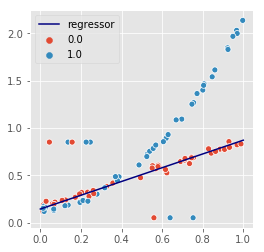

In [5]:
# Fit a linear regression, and the parameters of an adaptive loss.
regression = RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U)

torch.Size([100]) torch.Size([100])
torch.Size([100])
0   : loss=1.379435  alpha=1.004995  scale=0.993690
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([

torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
700 : loss=0.258501  alpha=1.401798  scale=0.230857
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size([100])
torch.Size([100])
torch.Size([100]) torch.Size

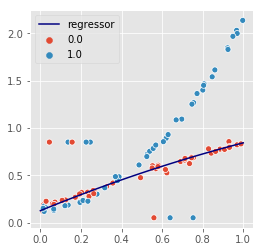

In [9]:
# Fit a linear regression with 2D base expansion, and the parameters of an adaptive loss.
regression = Poly2RegressionModel() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    print(y_i.shape, y.shape)
    print((y_i - y).shape)
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U)

## Linear regression with Adaptive Roust loss (Model knows group assignment)

0   : loss=1.738886  alpha=1.004995  scale=0.993690
100 : loss=0.407652  alpha=1.476729  scale=0.410891
200 : loss=0.145425  alpha=1.629173  scale=0.232751
300 : loss=0.132836  alpha=1.553619  scale=0.218783
400 : loss=0.124316  alpha=1.448755  scale=0.207770
500 : loss=0.119047  alpha=1.330386  scale=0.197023
600 : loss=0.115906  alpha=1.213221  scale=0.187254
700 : loss=0.113921  alpha=1.107793  scale=0.178839
800 : loss=0.112424  alpha=1.015406  scale=0.171597
900 : loss=0.110956  alpha=0.929151  scale=0.164845
1000: loss=0.108962  alpha=0.835103  scale=0.157361
1100: loss=0.104654  alpha=0.706164  scale=0.146561
1200: loss=0.086364  alpha=0.480201  scale=0.124226
1300: loss=0.014341  alpha=0.183108  scale=0.079632
1400: loss=-0.044472  alpha=0.061087  scale=0.049611
1500: loss=-0.070588  alpha=0.026628  scale=0.037447
1600: loss=-0.078442  alpha=0.015535  scale=0.033916
1700: loss=-0.081571  alpha=0.010835  scale=0.032766
1800: loss=-0.083220  alpha=0.008324  scale=0.032248
1900: l

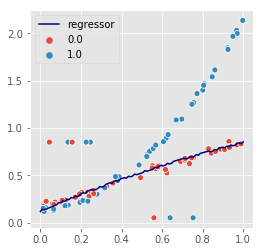

In [7]:
# Fit a linear regression with 2D base expansion, and the parameters of an adaptive loss.
regression = Poly2RegressionModel_with_class() 
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(
    num_dims = 1, float_dtype=np.float32, device='cpu')
params = list(regression.parameters()) + list(adaptive.parameters())
optimizer = torch.optim.Adam(params, lr = 0.01) 

for epoch in range(2000): 

    y_i = regression(x, U) 
    
    # Stealthily unsqueeze to an (n,1) matrix, and then compute the loss.
    # A matrix with this shape corresponds to a loss where there's one shape+scale parameter
    # per dimension (and there's only one dimension for this data).
    loss = torch.mean(adaptive.lossfun((y_i - y)[:,None]))

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    if np.mod(epoch, 100) == 0:
        # You can see the alpha+scale parameters moving around.
        print('{:<4}: loss={:03f}  alpha={:03f}  scale={:03f}'.format(
            epoch, loss.data, adaptive.alpha()[0,0].data, adaptive.scale()[0,0].data)) 

# It fits!
plot_regression(regression, U, U)